# Analysis with Coffea

<h2>Authors</h2>
<b>Notebook by:</b> Mat Adamec (<i>UNL</i>)
<br/>
<br/>
<b>coffea:</b>
<br/>
<a href="https://doi.org/10.5281/zenodo.6335374"><img src="https://zenodo.org/badge/DOI/10.5281/zenodo.6335374.svg" alt="DOI"></a>
<br/>
    <ul>
        <li>Lindsey Gray, Matteo Cremonesi, Bo Jayatilaka, Oliver Gutsche, Nick Smith, Allison Hall, Kevin Pedro, Maria Acosta <i>(FNAL)</i>; Andrew Melo <i>(Vanderbilt)</i>; Stefano Belforte <i>(INFN)</i>; and others</li>
        <li>In collaboration with IRIS-HEP members: Jim Pivarski <i>(Princeton)</i>, Ben Galewsky <i>(NCSA)</i>, Mark Neubauer <i>(UIUC)</i></li>
        <br/>
    </ul>
<b><a href="https://github.com/CoffeaTeam/coffea-casa">coffea-casa</a>:</b>
    <ul>
        <li>Ken Bloom, Oksana Shadura <i>(UNL)</i>; Garhan Attebury, Carl Lundstedt, Derek Weitzel <i>(UNL-HCC)</i>; Mátyás Selmeci <i>(UWM)</i>; Brian Bockelman <i>(Morgridge Institute)</i></li>
    </ul>

## Introduction

### What is columnar analysis?

The traditional way of analyzing data in HEP involves the event loop. In this paradigm, we would write an explicit loop to go through every event (and through every field of an event that we wish to make a cut on). This method of analysis is rather bulky in comparison to the columnar approach, which (ideally) has no explicit loops at all! Instead, the fields of our data are treated as arrays and analysis is done by way of numpy-like array operations.

<center><img src="utilities/columnar.png" alt="diagram of event loop vs. columnar paradigm" style="width:600px;"/></center>

In HEP, numpy is insufficient as our data is non-rectangular (an event can have a variable amount of muons, for example). This problem is resolved by [awkward arrays](https://awkward-array.org/quickstart.html).

### What is Coffea?

Awkward arrays let us access data in a columnar fashion, but that's just the first part of doing an analysis. Coffea builds upon this foundation with a variety of features that better enable us to do our analyses. These features include:

* **Hists** give us ROOT-like histograms. Actually, this is now a [standalone package](https://hist.readthedocs.io/en/latest/), but it has been heavily influenced by the (old) coffea hist subpackage, and it's a core component of the coffea ecosystem.

* **NanoEvents** allows us to apply a schema to our awkward array. This schema imposes behavior that we would not have in a simple awkward array, but which makes our (HEP) lives much easier. On one hand, it can serve to better organize our data by providing a structure for naming, nesting, and cross-referencing fields; on the other, it allows us to add physics object methods (e.g., for LorentzVectors).

* **Processors** are coffea's way of encapsulating an analysis in a way that is deployment-neutral. Once you have a Coffea analysis, you can throw it into a processor and use any of a variety of executors (e.g. Dask, Parsl, Spark) to chunk it up and run it across distributed workers. This makes scale-out simple and dynamic for users.

* **Lookup tools** are available in Coffea for any corrections that need to be made to physics data. These tools read a variety of correction file formats and turn them into lookup tables.

In summary, coffea's features enter the analysis pipeline at every step. They improve the usability of our input (NanoEvents), enable us to map it to a histogram output (Hists), and allow us tools for scaling and deployment (Processors).

### Looking Ahead

In this tutorial, we will show off coffea by doing a simple analysis and demonstrating how its features come in at every step. We will first go over some columnar analysis basics so that the general syntax is not wholly unfamiliar, and then we will seek to plot a Z-peak. We will use a [simulated Z->MuMu dataset](https://opendata.cern.ch/record/21587). It contains approximately 44000 events at 850 MB and is formatted in a generic ntuple format.

An Appendix is placed at the end of this notebook. It contains links to additional resources, as well as for topics which are beyond the scope of this tutorial.

### Imports

In [1]:
# Preliminary
## Columnar analysis basics.
import uproot
import awkward as ak
## Plotting.
import matplotlib.pyplot as plt

# Hists
import hist
from hist import Hist

# NanoEvents
from coffea.nanoevents import NanoEventsFactory, BaseSchema
# Processors
import coffea.processor as processor

## **Preliminary**: Columnar Analysis Basics

We begin our tutorial with a crash course through columnar analysis. This is meant to give a basic understanding of columnar operations, but for a more exhaustive introduction to the paradigm itself I recommend referring to an awkward tutorial (refer to the Appendix).

We begin by loading in our data. The standard way to do this is with [uproot](https://uproot.readthedocs.io/en/latest/index.html).

In [2]:
events = uproot.open('https://xrootd-local.unl.edu:1094//store/user/AGC/zmumu/RunIIFall15MiniAODv2/ZToMuMu_NNPDF30_13TeV-powheg_M_50_120/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12-v1/20000/022FAAEA-1BB9-E511-A6DF-44A842CFD5D8.root')['events']
events

<TTree 'events' (214 branches) at 0x7f39405477c0>

We now have an events tree. We can view its branches by querying its <code>keys()</code>:

In [3]:
events.keys()

['numberelectron',
 'nelectron_e',
 'electron_e',
 'nelectron_pt',
 'electron_pt',
 'nelectron_px',
 'electron_px',
 'nelectron_py',
 'electron_py',
 'nelectron_pz',
 'electron_pz',
 'nelectron_eta',
 'electron_eta',
 'nelectron_phi',
 'electron_phi',
 'nelectron_ch',
 'electron_ch',
 'nelectron_iso',
 'electron_iso',
 'nelectron_isLoose',
 'electron_isLoose',
 'nelectron_isMedium',
 'electron_isMedium',
 'nelectron_isTight',
 'electron_isTight',
 'nelectron_dxy',
 'electron_dxy',
 'nelectron_dz',
 'electron_dz',
 'nelectron_dxyError',
 'electron_dxyError',
 'nelectron_dzError',
 'electron_dzError',
 'numGenPart',
 'nGenPart_pt',
 'GenPart_pt',
 'nGenPart_eta',
 'GenPart_eta',
 'nGenPart_mass',
 'GenPart_mass',
 'nGenPart_pdgId',
 'GenPart_pdgId',
 'nGenPart_phi',
 'GenPart_phi',
 'nGenPart_px',
 'GenPart_px',
 'nGenPart_py',
 'GenPart_py',
 'nGenPart_pz',
 'GenPart_pz',
 'nGenPart_status',
 'GenPart_status',
 'numberjet',
 'njet_e',
 'jet_e',
 'njet_pt',
 'jet_pt',
 'njet_px',
 'jet_p

Each of these branches can be interpreted as an awkward array. Let's examine their contents. Since this is a mumu dataset, it seems natural to look at muons.

In [4]:
muon_pt = events['muon_pt'].array()
print(muon_pt)

[[51, 40.7, 3.24], [48.3, 40.3], [34.6, ... [29.1], [55.2, 34, 3.13, 1.53, 1.08]]


It's instructive to take a closer look at the structure of this array. First, we see that it is an array of subarrays. Each subarray represents one event, and each element of a subarray represents one muon. It is now clear what we mean by "non-rectangular data." There are a variable amount of muons, so the subarrays are not of equal size.

If we look at another (non-muon) branch, we would expect it to have the same amount of subarrays, but not necessarily the same amount of elements in each subarray. For comparison, let's now look at electrons:

In [5]:
electron_pt = events['electron_pt'].array()
print(electron_pt)

[[], [], [], [], [], [], [], [8.26], [], ... [], [], [], [], [], [], [], [], []]


In which case it is clear that there are not the same amount of elements in each subarray (most are empty!)

To drive the point home, we can also prove that there is an equal amount of subarrays:

In [6]:
ak.num(electron_pt, axis=0), ak.num(muon_pt, axis=0)

(43962, 43962)

A quick note about axes in awkward: 0 is always the shallowest, while -1 is the deepest. In other words, <code>axis=0</code> would tell us the number of subarrays (events), while <code>axis=-1</code> would tell us the number of muons within each subarray:

In [7]:
ak.num(electron_pt, axis=-1), ak.num(muon_pt, axis=-1)

(<Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='43962 * int64'>,
 <Array [3, 2, 3, 2, 2, 2, ... 1, 1, 2, 3, 1, 5] type='43962 * int64'>)

Then, if we wanted to know the total number of objects (muons or electrons) in our branch, we could just sum up the above output. Given this is a mumu dataset, we'd expect roughly twice as many muons as events and very few electrons. Let's verify this:

In [8]:
ak.sum(ak.num(electron_pt, axis=-1)), ak.sum(ak.num(muon_pt, axis=-1))

(9903, 92259)

Okay - so we can access data. How do we actually manipulate it to do analysis? Well, most simple cuts can be handled by masking. A mask is a Boolean array which is generated by applying a condition to a data array. For example, if we want only muons with p<sub>T</sub> > 10, our mask would be:

In [9]:
print(muon_pt > 10)

[[True, True, False], [True, True], ... [True], [True, True, False, False, False]]


Then, we can apply the mask to our data. The syntax follows other standard array selection operations: <code>data[mask]</code>. This will pick out only the elements of our data which correspond to a <code>True</code>. 

Let's pause and consider the details of this methodology. Our mask in this case must have the same shape as our muons branch, and this is guaranteed to be the case since it is generated from the data in that branch. When we apply this mask, the output should have the same amount of events, but it should down-select muons - muons which correspond to False should be dropped. Let's compare to check:

In [10]:
print('Input:', muon_pt)
print('Output:', muon_pt[muon_pt > 10])

Input: [[51, 40.7, 3.24], [48.3, 40.3], [34.6, ... [29.1], [55.2, 34, 3.13, 1.53, 1.08]]
Output: [[51, 40.7], [48.3, 40.3], [34.6], [28.4, ... [43.6, 37.2], [29.1], [55.2, 34]]


We can also confirm we have fewer muons now, but the same amount of events:

In [11]:
print('Input Counts:', ak.sum(ak.num(muon_pt, axis=1)))
print('Output Counts:', ak.sum(ak.num(muon_pt[muon_pt > 10], axis=1)))

print('Input Size:', ak.num(muon_pt, axis=0))
print('Output Size:', ak.num(muon_pt[ak.num(muon_pt)], axis=0))

Input Counts: 92259
Output Counts: 57514
Input Size: 43962
Output Size: 43962


What if we wanted to do a selection on our events, rather than on our muons? Then we'd just need a mask with the same length as our events array, with a <code>True</code> or <code>False</code> entry in place of the subarray instead of the element of the subarray. For example, we might want to select events which have at least one electron. Then our mask would be:

In [12]:
ak.num(electron_pt) >= 1

<Array [False, False, False, ... False, False] type='43962 * bool'>

Which you can note does not have the same structure as the muon cut above; it is a flat array. Applying the mask:

In [13]:
print('Input:', electron_pt)
print('Output:', electron_pt[ak.num(electron_pt) >= 1])

Input: [[], [], [], [], [], [], [], [8.26], [], ... [], [], [], [], [], [], [], [], []]
Output: [[8.26], [10.2], [6.16], [8.67], [4.92], ... [4.49], [2.34], [2.5], [2.5], [52.5]]


You can see that the empty arrays have been removed since they don't meet the cut, and the first entry is now the 8.26 we saw in our input. If we look at the size of our input and output arrays now, we will see a discrepency because we have thrown our our empty events:

In [14]:
print('Input Size:', ak.num(electron_pt, axis=0))
print('Output Size:', ak.num(electron_pt[ak.num(electron_pt) >= 1], axis=0))

Input Size: 43962
Output Size: 8359


Of course, in this case we still have the same amount of electrons. We've just gotten rid of empty events.

In [15]:
print('Input Counts:', ak.sum(ak.num(electron_pt, axis=1)))
print('Output Counts:', ak.sum(ak.num(electron_pt[ak.num(electron_pt > 10) >= 1], axis=1)))

Input Counts: 9903
Output Counts: 9903


These sorts of cuts are how the bulk of columnar analysis can be done. Awkward comes equipped with features for other standard operations, such as combinatorics and an analogue to <code>np.where()</code> (<code>ak.where()</code>). Other resources (listed in the appendix) cover it more extensively and do it better justice.

Nonetheless, there are a couple of things which aren't exactly pretty. For example, what if we want LorentzVector operations? The nicest way to handle this is with coffea schemas.

## **NanoEvents**

Before we can dive into our Z-peak analysis, we need to spruce up our data a bit.

Let's turn our attention to NanoEvents and schemas. Schemas let us better organize our file and impose physics methods onto our data. There exist schemas for some standard file formats, most prominently NanoAOD, and there is a <code>BaseSchema</code> which operates much like uproot. The coffea development team welcomes community development of other schemas and it is not so difficult to do so.

For the purposes of this tutorial, I have already made a schema. We won't go into the details, but we will show off its features and the general structure. First, let's take a look at our data structure again. Because there's a lot of branches, we'll zoom in on the muon-related ones here:

In [16]:
branches = uproot.open("https://xrootd-local.unl.edu:1094//store/user/AGC/zmumu/RunIIFall15MiniAODv2/ZToMuMu_NNPDF30_13TeV-powheg_M_50_120/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12-v1/20000/022FAAEA-1BB9-E511-A6DF-44A842CFD5D8.root")['events']

for branch in branches.keys():
    if 'muon' in branch:
        print(branch)

numbermuon
nmuon_e
muon_e
nmuon_pt
muon_pt
nmuon_px
muon_px
nmuon_py
muon_py
nmuon_pz
muon_pz
nmuon_eta
muon_eta
nmuon_phi
muon_phi
nmuon_ch
muon_ch
nmuon_isSoft
muon_isSoft
nmuon_isTight
muon_isTight
nmuon_dxy
muon_dxy
nmuon_dz
muon_dz
nmuon_dxyError
muon_dxyError
nmuon_dzError
muon_dzError
nmuon_pfreliso03all
muon_pfreliso03all
nmuon_pfreliso04all
muon_pfreliso04all
nmuon_jetidx
muon_jetidx
nmuon_genpartidx
muon_genpartidx


By default, uproot (and <code>BaseSchema</code>)  treats all of the muon branches as distinct branches with distinct data. This is not ideal, as some of our data is redundant, e.g., all of the <code>nmuon_*</code> branches better have the same counts. Further, we'd expect all the <code>muon_*</code> branches to have the same shape, as each muon should have an entry in each branch.

The first benefit of instating a schema, then, is a standardization of our fields. It would be more succinct to create a general <code>muon</code> collection under which all of these branches (in NanoEvents, <i>fields</i>) with identical size can be housed, and to scrap the redundant ones. We can use <code>numbermuon</code> to figure out how many muons should be in each subarray (the counts, or offsets), and then fill the contents with each <code>muon_*</code> field. We can repeat this for the other branches.

In [17]:
from agc_schema import AGCSchema
agc_events = NanoEventsFactory.from_root('https://xrootd-local.unl.edu:1094//store/user/AGC/zmumu/RunIIFall15MiniAODv2/ZToMuMu_NNPDF30_13TeV-powheg_M_50_120/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12-v1/20000/022FAAEA-1BB9-E511-A6DF-44A842CFD5D8.root', schemaclass=AGCSchema, treepath='events').events()

For NanoEvents, there is a slightly different syntax to access our data. Instead of querying <code>keys()</code> to find our fields we query <code>fields</code>. We can still access specific fields as we would navigate a dictionary (<code>collection[field]</code>) or we can navigate them in a new way: <code>collection.field</code>.

Let's take a look at our fields now:

In [18]:
agc_events.fields

['electron', 'jet', 'tau', 'trigobj', 'photon', 'muon', 'met', 'GenPart', 'PV']

We can confirm that no information has been lost by querying the <code>fields</code> of our event fields:

In [19]:
agc_events.muon.fields

['pt',
 'px',
 'py',
 'pz',
 'eta',
 'phi',
 'ch',
 'isSoft',
 'isTight',
 'dxy',
 'dz',
 'dxyError',
 'dzError',
 'pfreliso03all',
 'pfreliso04all',
 'jetidx',
 'genpartidx',
 'energy']

All of the branches above are still here, just as fields of our new electron collection. We can confirm this matches our original counts from uproot:

In [20]:
branches['numbermuon'].array(), ak.num(agc_events.muon)

(<Array [3, 2, 3, 2, 2, 2, ... 1, 1, 2, 3, 1, 5] type='43962 * int32'>,
 <Array [3, 2, 3, 2, 2, 2, ... 1, 1, 2, 3, 1, 5] type='43962 * int64'>)

So, aesthetically, everything is much nicer. If we had a messier dataset, the schema can also standardize our names to get rid of any quirks. For example, every physics object in our tree has a <code>number{name}</code> field except for GenPart, which has <code>num{name}</code>. This discrepancy is irrelevant after the application of the schema, so we don't have to worry about it.

There are also other benefits to this structure: as we now have a collection object (<code>agc_events.muon</code>), there is a natural place to impose physics methods. By default, this collection object does nothing - it's just a category. But we're physicists, and we often want to deal with Lorentz vectors. Why not treat these objects as such?

This behavior can be built fairly simply into a schema simply by specifying that it is a <code>PtEtaPhiELorentzVector</code> and having the appropriate fields present in each collection (in this case, pt, eta, phi and e). This makes mathematical operations on our <code>muon</code>s well-defined:

In [21]:
agc_events.muon[0, 0] + agc_events.muon[0, 1]

<LorentzVectorRecord ... y: -20.9, z: 150, t: 179} type='LorentzVector["x": floa...'>

And it gives us access to all of the standard LorentzVector methods:

In [22]:
agc_events.muon[0, 0].delta_r(agc_events.muon[0, 1])

2.5734195315471506

We can also access other LorentzVector formulations, if we want, as the conversions are built-in:

In [23]:
agc_events.muon.x, agc_events.muon.y, agc_events.muon.z, agc_events.muon.mass

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


(<Array [[4.64, -27.7, -2.24, ... -1.03, 0.934]] type='43962 * var * float32'>,
 <Array [[-50.8, 29.8, -2.34, ... 1.13, 0.547]] type='43962 * var * float32'>,
 <Array [[53.9, 96.3, 12.7, ... 4.28, -4.16]] type='43962 * var * float32'>,
 <Array [[0.104, 0.108, ... 0.106, 0.106]] type='43962 * var * float32'>)

 NanoEvents can also impose other features, such as cross-references in our data.
 
 ** Add a small cross-ref example

In [24]:
agc_events.muon.fields

['pt',
 'px',
 'py',
 'pz',
 'eta',
 'phi',
 'ch',
 'isSoft',
 'isTight',
 'dxy',
 'dz',
 'dxyError',
 'dzError',
 'pfreliso03all',
 'pfreliso04all',
 'jetidx',
 'genpartidx',
 'energy']

## **Hists**

With an understanding of basic columnar analysis and our data in the proper format, we are finally ready to turn our attention to our analysis. We want to plot the Z-peak. This involves plotting the pair-mass of leptons which have the same flavor (ee or mumu) and opposite sign. To discard anomalies, we also want to toss out leptons with less than 10 p<sub>T</sub>. This selection is trivial in the columnar paradigm.

A couple of notes: since they're same-flavor, we can consider dimuons and dielectrons independently. Also, since this is a Z -> mumu dataset, we'd only expect to see the Z-peak for muons. There should be few electrons plotted.

In [25]:
muons = agc_events.muon[agc_events.muon.pt > 10]
electrons = agc_events.electron[agc_events.electron.pt > 10]

dimuons = muons[(ak.num(muons, axis=1) == 2) & (ak.sum(muons.ch, axis=1) == 0)]
dielectrons = electrons[(ak.num(electrons, axis=1) == 2) & (ak.sum(electrons.ch, axis=1) == 0)]

Our <code>dimuons</code> array should now contain only opposite-charge muon pairs and our <code>dielectrons</code> opposite-charge electron pairs. Let's check!

In [26]:
dimuons, dielectrons

(<PtEtaPhiELorentzVectorArray [[{pt: 51, px: 4.64, ... energy: 79.9}]] type='2003...'>,
 <PtEtaPhiELorentzVectorArray [[{pt: 26.3, ... energy: 21.1}]] type='33 * var * P...'>)

Note that the masks performed a cut at the event level rather than the muon level. We have fewer events, but the same amount of leptons in each event (in the events that we kept). That means we've lost the connection between muons and electrons - they've been downselected and it is not the case that the 1st subarray in our electron array is the same event as the 1st subarray in our muon array. This isn't a problem since we're handling the two independently, but there are ways to handle such a selection without downselection if such indexing needs to be preserved.

All we need now is the dilepton mass. Awkward arrays can be indexed in a similar way as numpy arrays, so <code>dimuons[:, 0]</code> will select the first muon in every <code>dimuon</code> event. Recall that NanoEvents allows us to treat mathematical operations on the muon collection level as LorentzVector objects. The same goes for our electrons collection, of course. That makes our life easy:

In [27]:
mumu_mass = (dimuons[:, 0] + dimuons[:, 1]).mass
ee_mass = (dielectrons[:, 0] + dielectrons[:, 1]).mass

mumu_mass, ee_mass

(<Array [91.7, 85.8, 92.3, ... 90.9, 97.7, 96.2] type='20037 * float32'>,
 <Array [115, 1.07, 50.4, ... 1.21, 1.11, 0.989] type='33 * float32'>)

This has collapsed our subarrays because we're finding the mass of the pairs, so now we have a flat array. It is of the same size (respectively) as our dimuons and dielectrons arrays above. We now have our data!

What else do we need for plotting? Well, a histogram is essentially a way to reduce our data. We can't just plot every value of dimuon mass, so we divide up our range of masses into n bins across some reasonable range. Thus, we need to define the mapping for our reduction; defining the number of bins and the range is sufficient for this. This is called a <code>Regular</code> axis in the Hist package.

In our case, let's plot 50 bins between values of 10 and 150. We already have 10 as our lower bound on pT (from our selection), and so this merely cuts off a shrinking tail on the higher end. Because a histogram can contain an arbitrary amount of bins (in other words, dimensions), we also need to give our bin a name (which becomes its reference in our code) and a label (which is the label on the axis that users see when the histogram is plotted).

In [28]:
ll_bin = hist.axis.Regular(label="Dilepton Mass", name="dilep_mass", bins=50, start=10, stop=150)

We are still not *yet* ready to plot. We have two masses we'd like to plot, and it doesn't make much sense to throw ee masses into the same bins as $\mu\mu$ masses. We want to keep these separate. We do so by introducing a <code>Categorical</code> axis. Another example of when we might use a categorical axis is to keep data from different datasets separate, though in our case we're only working with a single dataset.

A <code>Categorical</code> axis takes a name, a label, and a pre-defined list of categories.

In [29]:
ll_cat = hist.axis.StrCategory(label='Leptons', name='lepton', categories=["ee", "$\mu\mu$"])

We finally have all of the ingredients needed for a histogram! All that remains is to put them together:

In [30]:
ll_hist = Hist(ll_bin, ll_cat)

And to fill it with our data:

In [31]:
ll_hist.fill(lepton="$\mu\mu$", dilep_mass=mumu_mass)
ll_hist.fill(lepton="ee", dilep_mass=ee_mass)

Hist(
  Regular(50, 10, 150, name='dilep_mass', label='Dilepton Mass'),
  StrCategory(['ee', '$\\mu\\mu$'], name='lepton', label='Leptons'),
  storage=Double()) # Sum: 20002.0 (20070.0 with flow)

And plot!

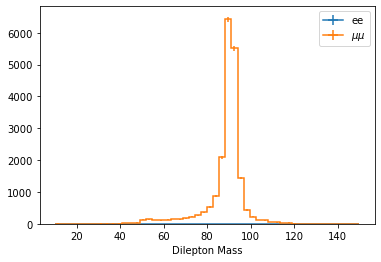

In [32]:
ll_hist.plot()
plt.legend()

We can see a peak at around 90 for our dimuon events. Indeed, the mass of a Z boson is ~91.18.

The Hist package is also capable of handling a variety of transormations to our histogram. You should refer to its documentation for more advanced features.

## **Processors**

![Diagram of coffea processor](utilities/processor.png)

In [33]:
import coffea.processor as processor

class Processor(processor.ProcessorABC):
    def __init__(self):
        ll_bin = hist.axis.Regular(label="Dilepton Mass", name="dilep_mass", bins=50, start=10, stop=150)
        ll_cat = hist.axis.StrCategory(label='Leptons', name='lepton', categories=["ee", "$\mu\mu$"])
        
        self._accumulator = Hist(ll_cat, ll_bin)
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator
        muons = events.muon[events.muon.pt > 10]
        electrons = events.electron[events.electron.pt > 10]
        
        dimuons = muons[(ak.num(muons, axis=1) == 2) & (ak.sum(muons.ch, axis=1) == 0)]
        dielectrons = electrons[(ak.num(electrons, axis=1) == 2) & (ak.sum(electrons.ch, axis=1) == 0)]
        mumu_mass = (dimuons[:, 0] + dimuons[:, 1]).mass
        ee_mass = (dielectrons[:, 0] + dielectrons[:, 1]).mass
        
        output.fill(lepton='$\mu\mu$', dilep_mass=mumu_mass)
        output.fill(lepton='ee', dilep_mass=ee_mass)
        
        return output
        
    def postprocess(self, accumulator):
        pass

In [34]:
fileset = {'SingleMu' : ['https://xrootd-local.unl.edu:1094//store/user/AGC/zmumu/RunIIFall15MiniAODv2/ZToMuMu_NNPDF30_13TeV-powheg_M_50_120/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12-v1/20000/022FAAEA-1BB9-E511-A6DF-44A842CFD5D8.root']}

from dask.distributed import Client
client = Client("tls://localhost:8786")
client.upload_file('agc_schema.py')

run = processor.Runner(executor=processor.DaskExecutor(client=client),
                      schema=AGCSchema,
                      chunksize=100000,
                      maxchunks=1)

output = run(fileset, "events", Processor())

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f37cedd7fd0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f37cef81d00>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

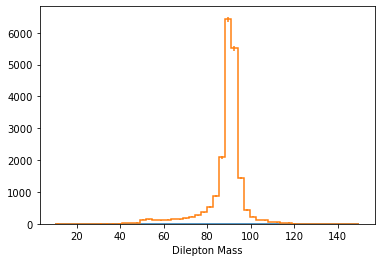

In [35]:
output.plot()

## Appendix

### Lookup Tables

### ServiceX

## Acknowledgements